## Техническое задание

### Загрузка и просмотр данных датасета

In [5]:
import pandas as pd
df = pd.read_excel("data.xlsx")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       724 non-null    float64
 1   sum             724 non-null    float64
 2   status          730 non-null    object 
 3   sale            724 non-null    object 
 4   new/current     724 non-null    object 
 5   Unnamed: 5      0 non-null      float64
 6   document        709 non-null    object 
 7   receiving_date  607 non-null    object 
dtypes: float64(3), object(5)
memory usage: 45.8+ KB


In [7]:
df.head(3)

,client_id,sum,status,sale,new/current,Unnamed: 5,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaN,NaN
1,6.0,11693.7,ВНУТРЕННИЙ,-,-,NaN,-,-
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,NaN,оригинал,2021-07-26 00:00:00


### Предобработка данных

In [8]:
df = df.drop('Unnamed: 5', axis=1)

In [9]:
df = df.drop_duplicates().reset_index(drop=True)

Было принято решение удалить все строки, дата в которых неопределена, поскольку большая часть запросов к получению информации из датасета завязаны именно на этом параметре

In [10]:
df = df[(df['receiving_date'] != '-') & (df['receiving_date'].notnull())]

### Обработка пропусков

In [11]:
df['client_id'] = df['client_id'].dropna().astype('int')

In [12]:
df['sale'] = df['sale'].fillna('-')

In [13]:
df['new/current'] = df['new/current'].fillna('-')

In [14]:
df['document'] = df['document'].replace('НЕТ', None).fillna('-')
df['document'] = df['document'].replace('-', False)
df['document'] = df['document'].replace('оригинал', True)
df['document'] = df['document'].astype('bool')

In [15]:
df['receiving_date'] = pd.to_datetime(df['receiving_date'])

### Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных средств которых не просрочен.

In [16]:
july_data = df[(df["status"] != "ПРОСРОЧЕНО") & (df["receiving_date"].dt.month == 7)]
july_revenue = july_data["sum"].sum()

print(f"Общая выручка за июль 2021 по тем сделкам, приход денежных средств которых не просрочен составила {(july_revenue).round(2)}")

Общая выручка за июль 2021 по тем сделкам, приход денежных средств которых не просрочен составила 729541.14


### Как изменялась выручка компании за рассматриваемый период? Проиллюстрируйте графиком.

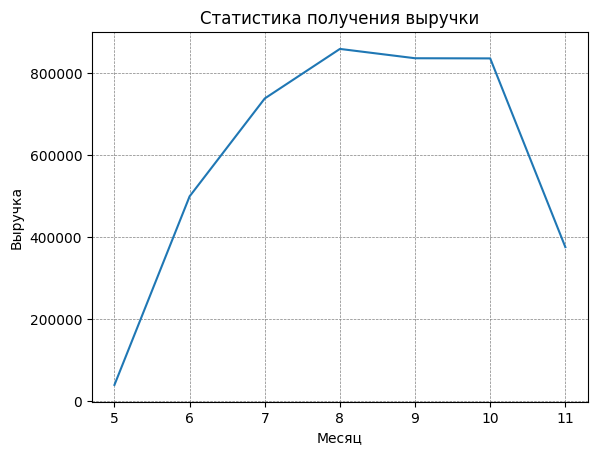

In [17]:
import matplotlib.pyplot as plt

monthly_data = df.groupby(df["receiving_date"].dt.month)["sum"].sum()

plt.plot(monthly_data.index, monthly_data.values)
plt.xlabel("Месяц")
plt.ylabel("Выручка")
plt.title("Статистика получения выручки")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()


### Кто из менеджеров привлек для компании больше всего денежных средств в сентябре 2021?

In [18]:
september_data = df[(df["status"] == "ОПЛАЧЕНО") & (df["receiving_date"].dt.month == 9)]
september_sales = september_data.groupby("sale")["sum"].sum()
max_revenue = september_sales.max()
best_manager = september_sales.idxmax()

print(f"Лучший менеджер за сентябрь 2021 - {best_manager}, принес {max_revenue}")

Лучший менеджер за сентябрь 2021 - Петрова, принес 189848.62


### Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?

In [19]:
october_data = df[df["receiving_date"].dt.month == 10]
october_deals = october_data["new/current"].value_counts()
max_count = october_deals.max()
dominant_type = october_deals.idxmax()

print(f'Преобладающим типом сделок в октябре 2021 стал "{dominant_type}", всего {max_count} сделок')

Преобладающим типом сделок в октябре 2021 стал "текущая", всего 99 сделок


### Сколько оригиналов договора по майским сделкам было получено в июне 2021?

На данный вопрос из данных ответ получить я не смог, поскольку в данных нет информации о дате проведения самой сделки, только о получении договора, но примерный код получения этих данных пог бы выглядеть так:

In [ ]:
# Получаем данные о договорах, полученных в июне
june_data = df[df["receiving_date"].dt.month == 6]
# Получаем данные о договорах, полученных в июне, где есть оригинал договора
june_contracts = june_data[june_data["document"] == True]
# Получаем данные о сделках, проведенных в мае
may_contracts = june_contracts[june_contracts["contract_receiving_date"].dt.month == 5].shape[0]

### Задание:
За каждую заключенную сделку менеджер получает бонус, который рассчитывается следующим образом.

1. За новые сделки менеджер получает 7 % от суммы, при условии, что статус оплаты «ОПЛАЧЕНО», а также имеется оригинал подписанного договора с клиентом (в рассматриваемом месяце).
2. За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс., и 3 % от суммы, если меньше. При этом статус оплаты может быть любым, кроме «ПРОСРОЧЕНО», а также необходимо наличие оригинала подписанного договора с клиентом (в рассматриваемом месяце).

Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого месяца, считаются остатком на следующий период, который выплачивается по мере
прихода оригиналов. Вычислите остаток каждого из менеджеров на 01.07.2021.

In [21]:
def bonus(deal_type, deal_sum, status, document, date):
    if date > pd.to_datetime('2021-07-01'):
        return 0
    if deal_type == "новая" and status == "ОПЛАЧЕНО" and document == True:
        return deal_sum * 0.07
    elif deal_type == "текущая" and status != "ПРОСРОЧЕНО" and document == True:
        if deal_sum > 10000:
            return deal_sum * 0.05
        else:
            return deal_sum * 0.03
    else:
        return 0
    
df["bonus"] = df.apply(lambda row: bonus(row["new/current"], row["sum"], row["status"], row["document"], row['receiving_date']), axis=1)

manager_bonus = df.groupby("sale")["bonus"].sum()

print(manager_bonus)


sale
Андреев       4701.7537
Васильев       339.2310
Иванов        2716.5000
Кузнецова     2604.6716
Михайлов         0.0000
Петрова       7028.8020
Селиванов      353.3220
Смирнов       4219.5170
Соколов          0.0000
Филимонова     409.6830
Name: bonus, dtype: float64
